In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

#### Code 2.1

In [3]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

#### Code 2.2

The binomial distribution has a probability mass function:

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$


[SciPy.org](https://scipy.org/) provides open source scientific computing algorithms.  The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) library has a large number of statistical functions and among the probability distribution functions it provides is the [binomial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom) distripbution.  Here we use its probability mass function to compute the probability of observing six $w$’s in nine tosses with a value of $p=0.5$.

In [4]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

#### Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book, the following code is not inside a function, but it will help us to do more experiments with our data if we do have it in a function.  This is the first line of code in `R code 2.3`.

In [5]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)

We will also put the code for doing a grid approximation into a function so that we can more easily make changes later.  The following is the rest of `R code 2.3`.

In [6]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

#### Code 2.4

We are going to plot our grid approximation for each of three grid spacings, 5, 20 and 100 points.

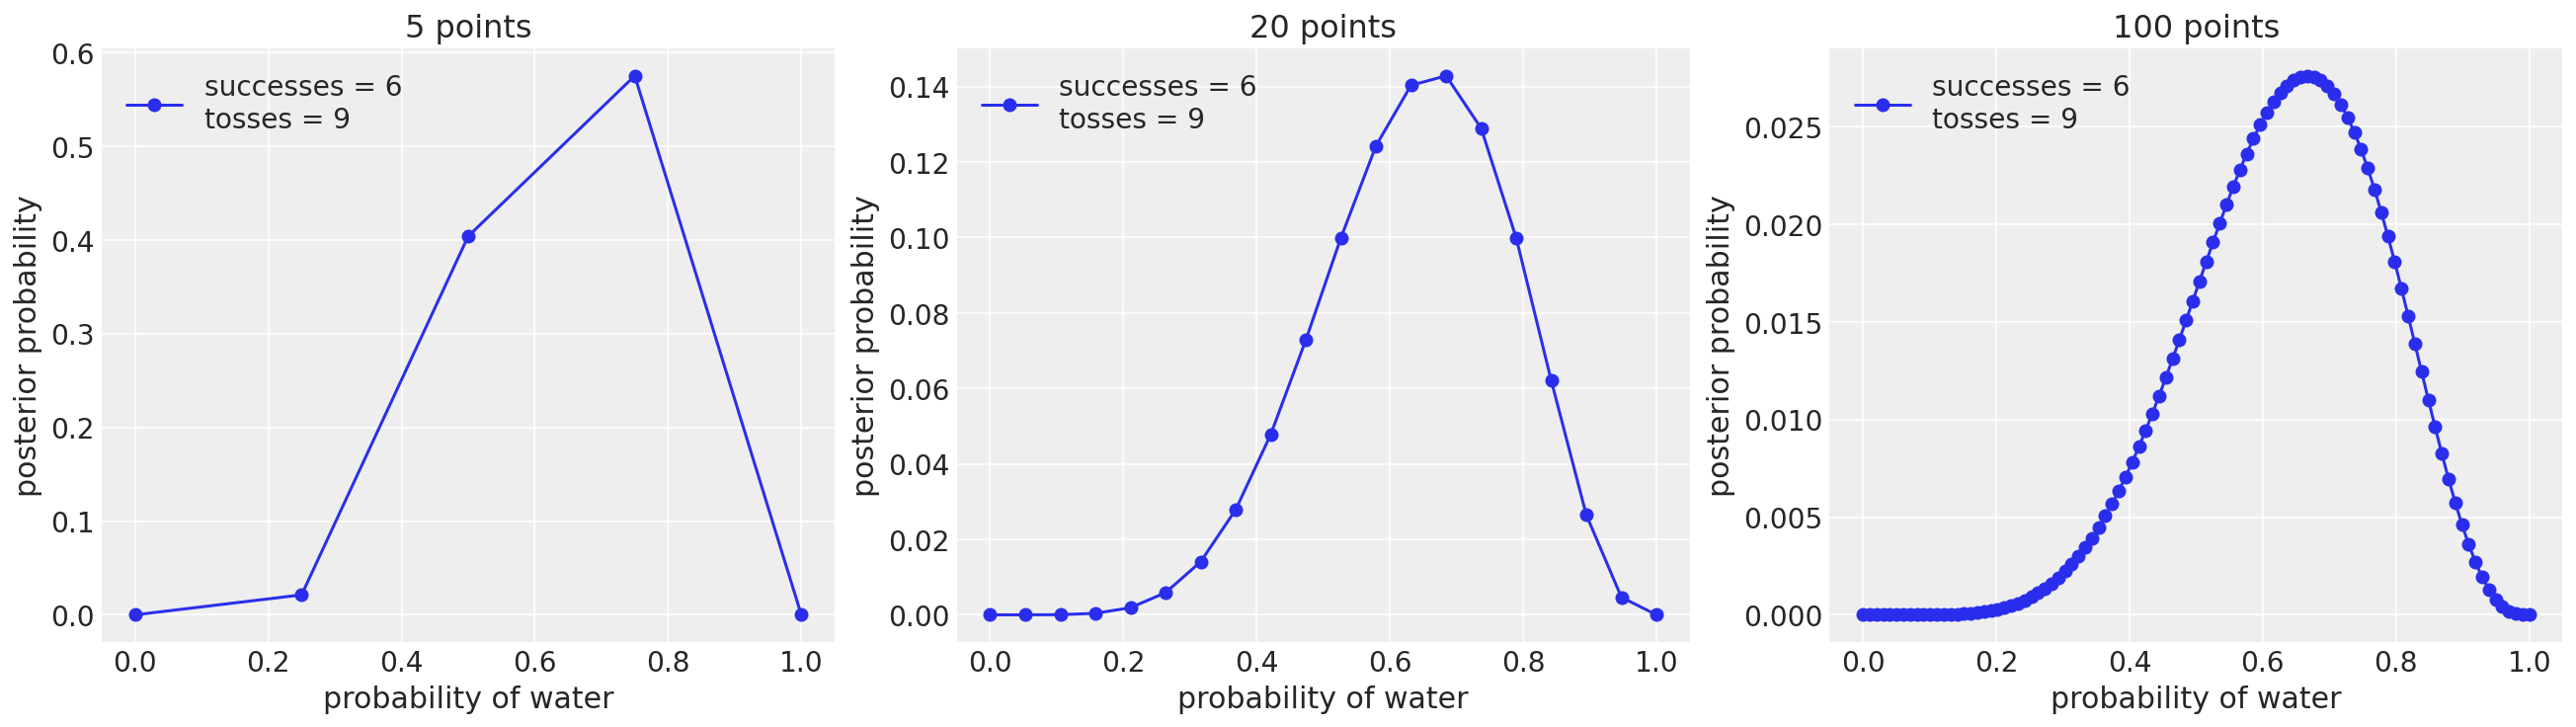

In [7]:
w, n = 6, 9

points = (5, 20, 100)

_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(uniform_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

#### Code 2.5

We are going to use two other priors, a truncated prior and what could be called a double-exponential prior as suggested in Figure 2.6.

In [8]:
def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

#### Code 2.3

Text(0.5, 0.98, 'Using a Truncated Prior')

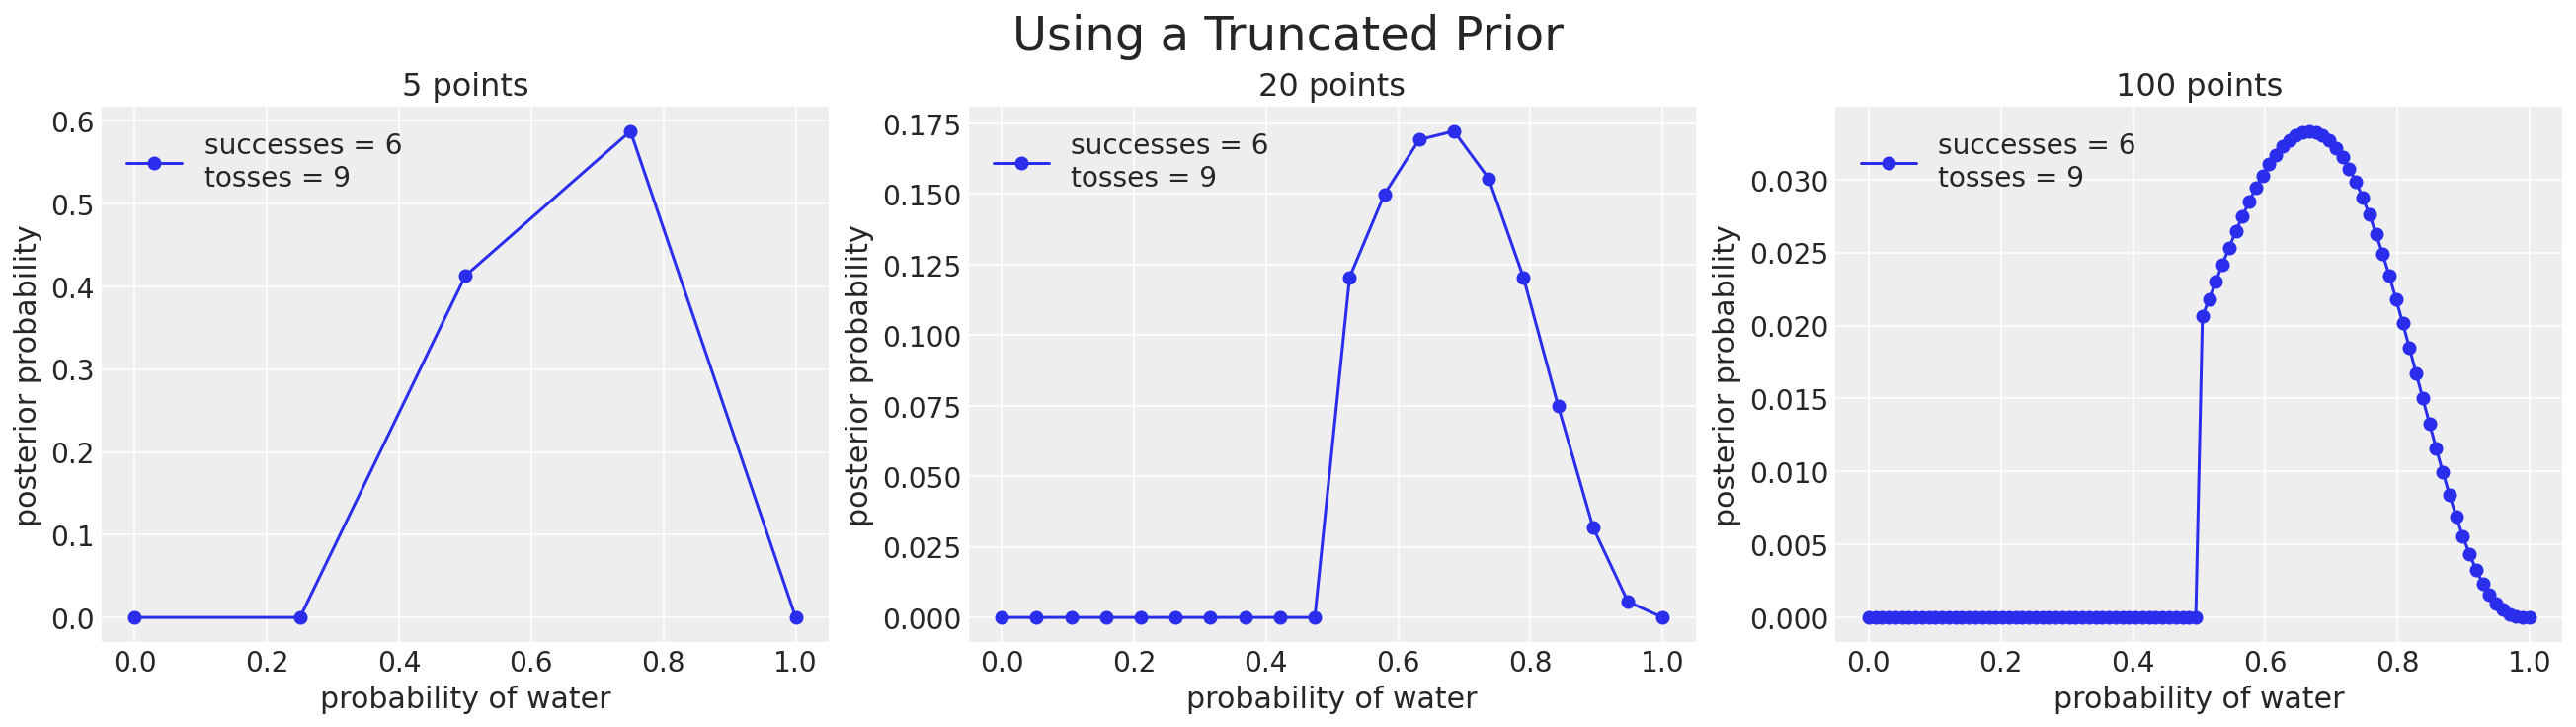

In [9]:
fig, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(truncated_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)
fig.suptitle("Using a Truncated Prior", fontsize=24)

Text(0.5, 0.98, 'Using a `Peaked` Prior')

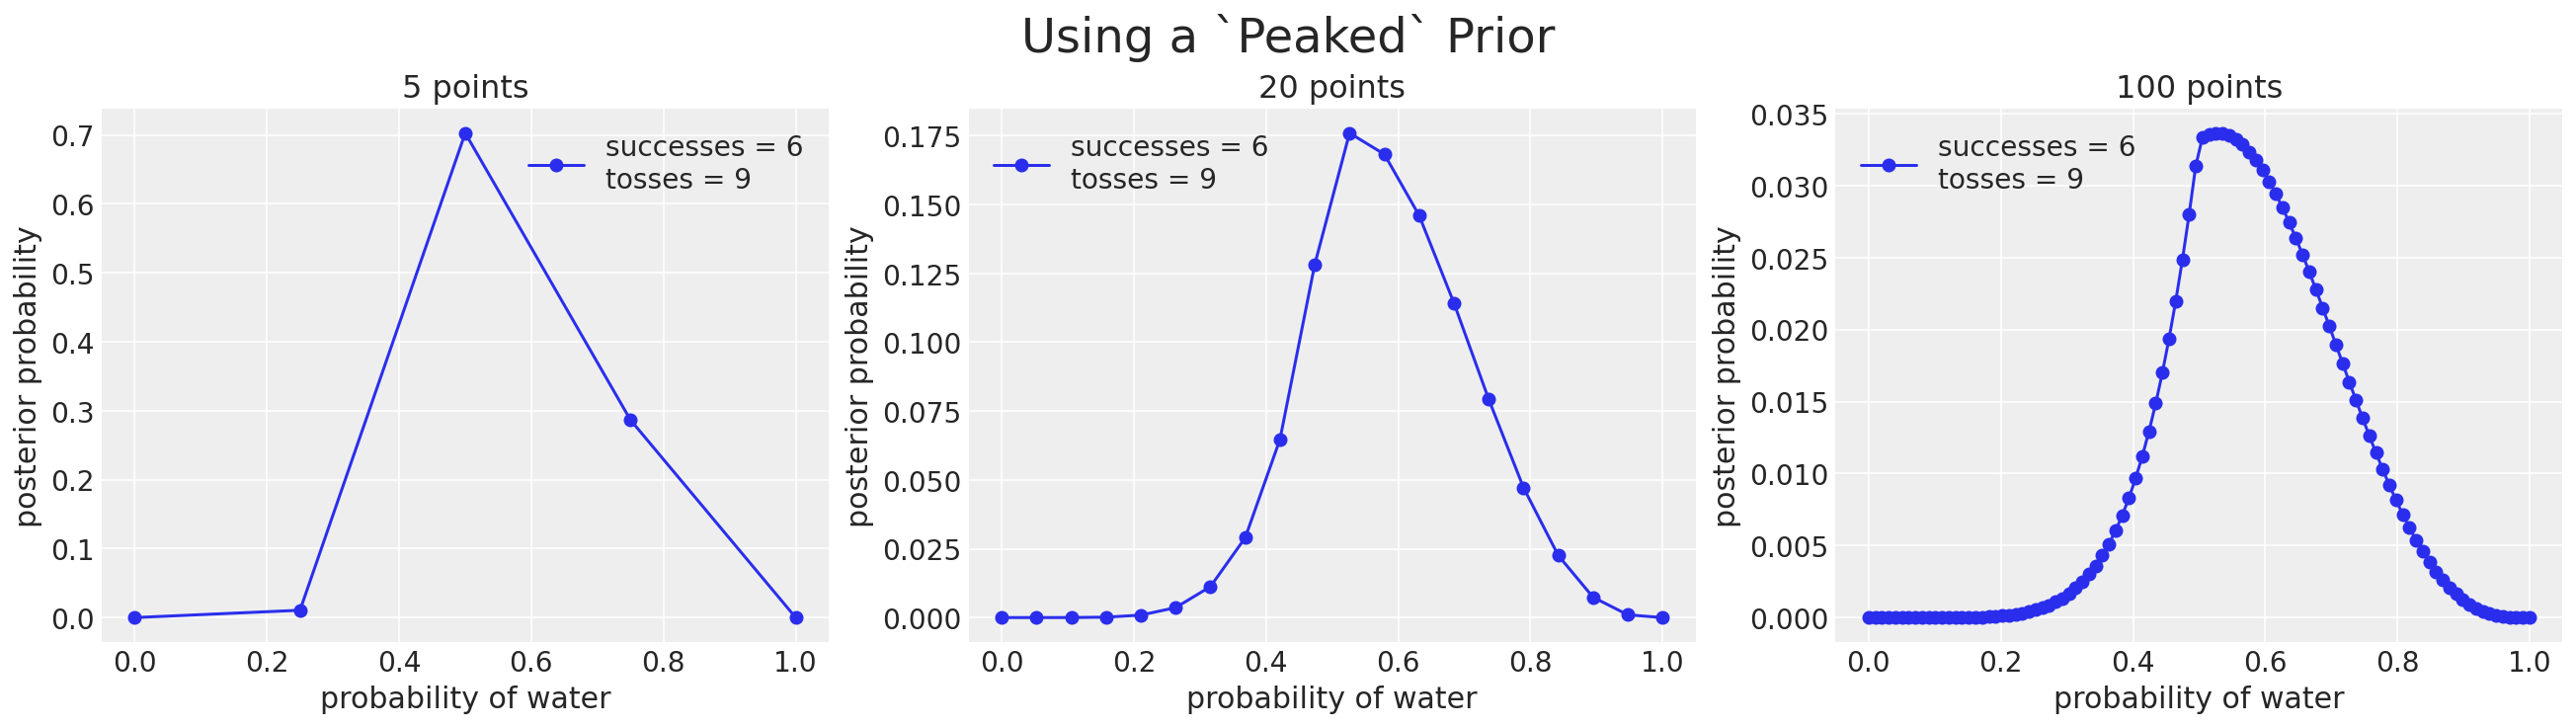

In [10]:
fig, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(double_exp_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)
fig.suptitle("Using a `Peaked` Prior", fontsize=24)

#### Code 2.6

Computing the posterior using the quadratic approximation.  The `rethinking` package nicely hides the implementation details that we are exposing below but the gist of what it does is summarized on page 42 as:
- Finds the local maximum of the posterior
- Estimate the curvature at that point

In [11]:
# simulate the globe tossing data that we have.  Water = 1, land = 0, tosses = 9
data = np.repeat((0, 1), (3, 6))

with pm.Model() as quadratic_approximation:
    # the next two lines are the alist in the text.
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood conditioned on our data
    # First we find the maximim a posteriori point
    mean_q = pm.find_MAP()
    # normalize
    p_value = quadratic_approximation.rvs_to_values[p]
    p_value.tag.transform = None
    p_value.name = p.name
    # then the Hessian evaluated at that point lets us estimate the standard deviation 
    # see Overthininkg: on page 44.
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

# display summary of quadratic approximation
print("Mean, Standard deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))


Mean, Standard deviation
p 0.67, 0.16


In [12]:
# freeze an instance of the normal distribution with our desired paramaters, mean_p and std_q
norm = stats.norm(mean_q, std_q)
# Compute the 89% percentile interval
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))

5.5%, 94.5% 
0.42, 0.92


#### Code 2.7

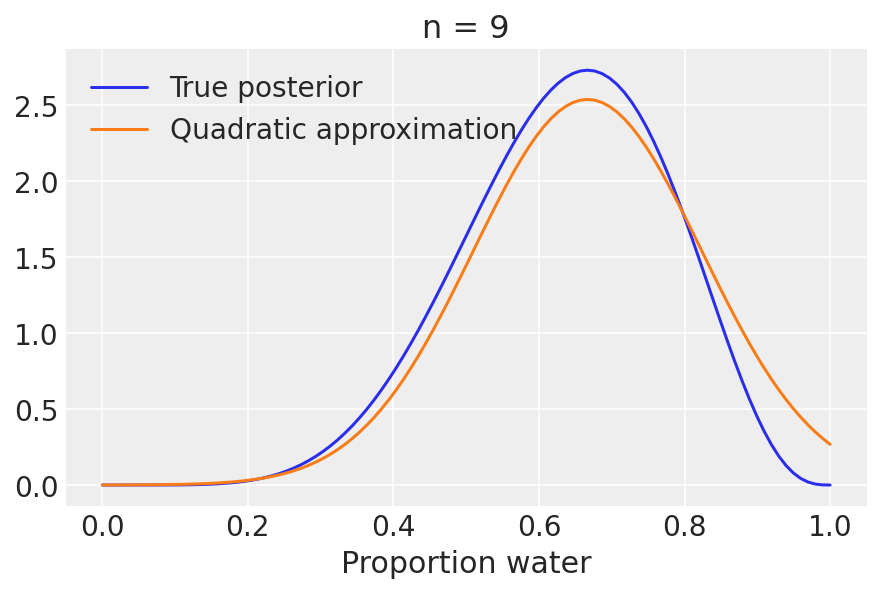

In [13]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

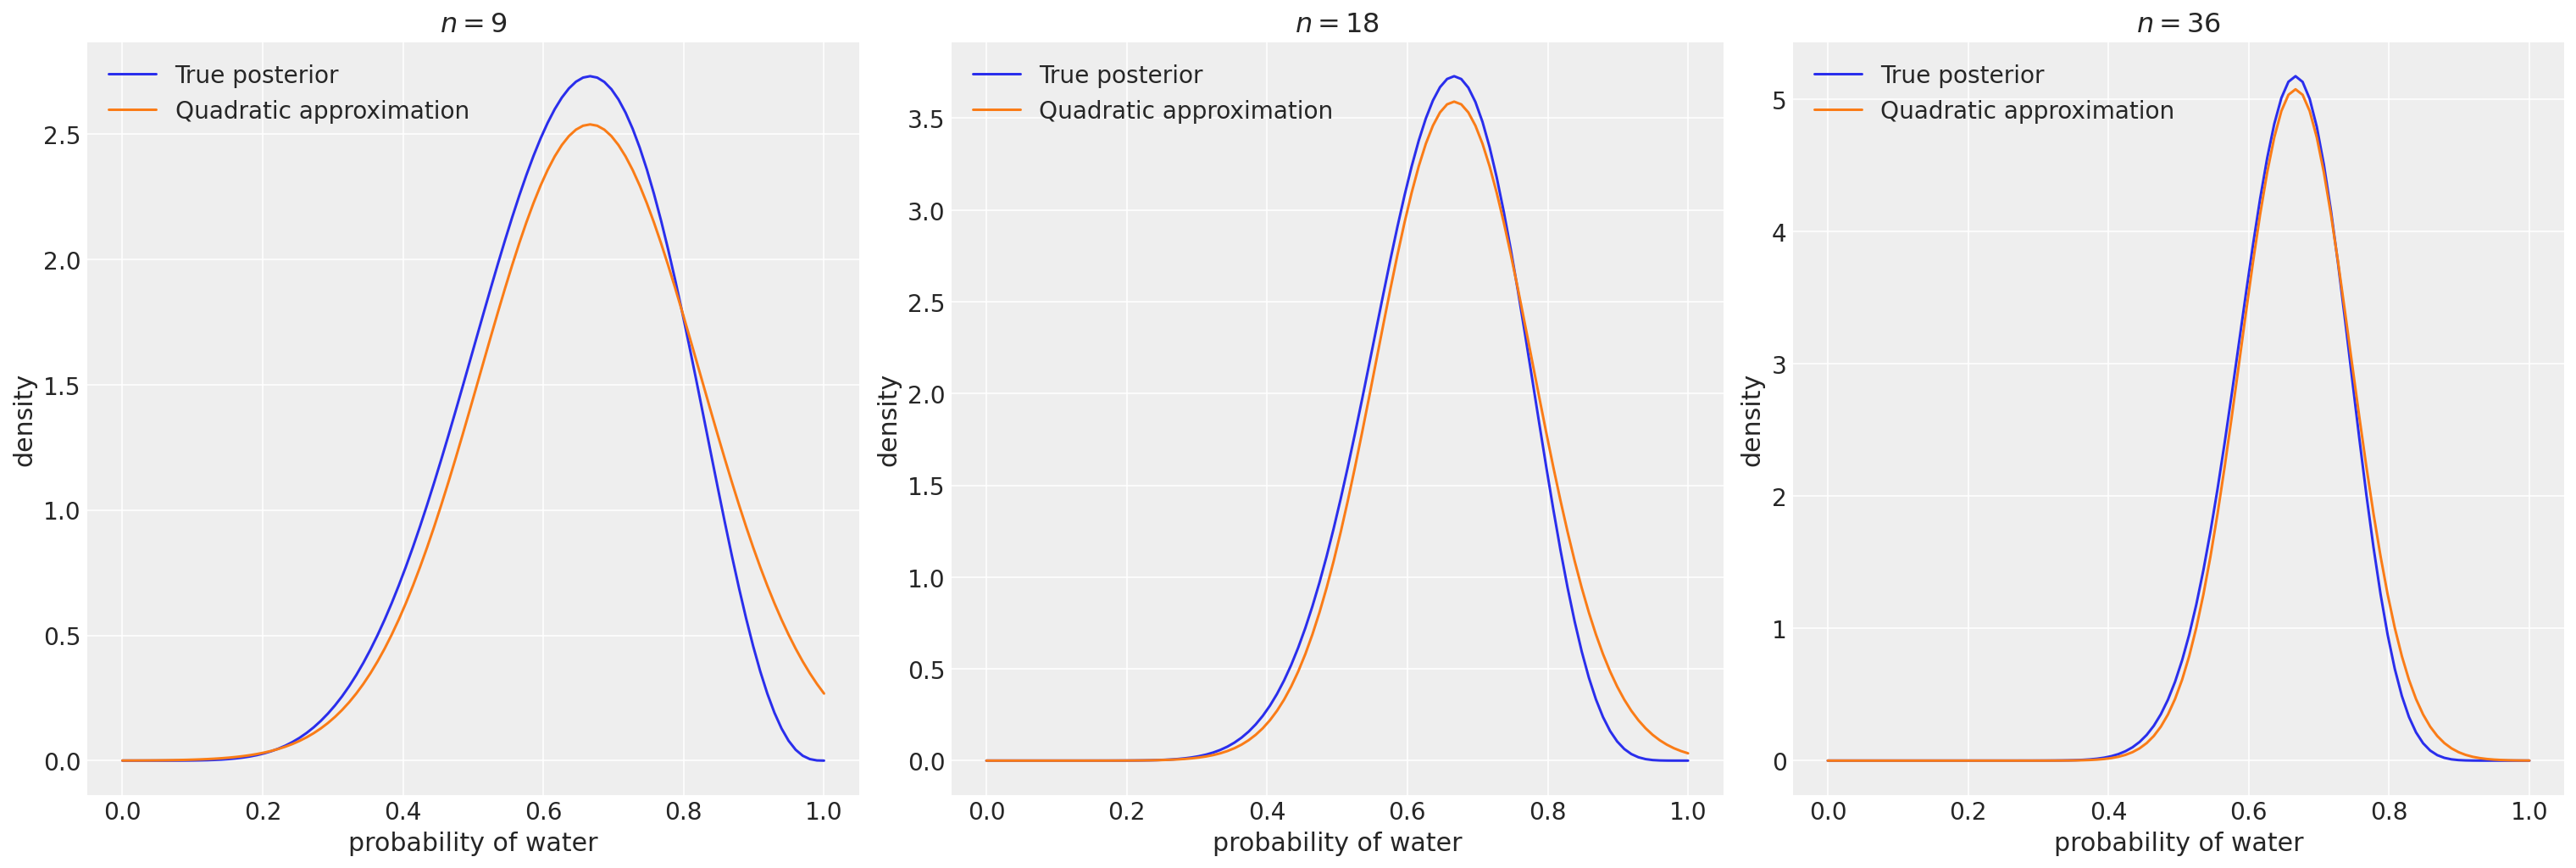

In [14]:
# Figure 2.8
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

for idx, ps in enumerate(zip(w, n)):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()
        # normalize
        p_value = normal_approximation.rvs_to_values[p]
        p_value.tag.transform = None
        p_value.name = p.name

        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))
    ax[idx].legend(loc="upper left")

#### Code 2.8

In [15]:
n_samples = 1000
p = np.zeros(n_samples)
# pick a starting value
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    # determine which direction we will move next via a Gausian process.
    # that is to say pick a sample from a normal distribution centered on our previous value
    # with a standard deviation of 0.1
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    # calculate the Acceptance Ratio
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    # accept or reject based on the Acceptance Ratio
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

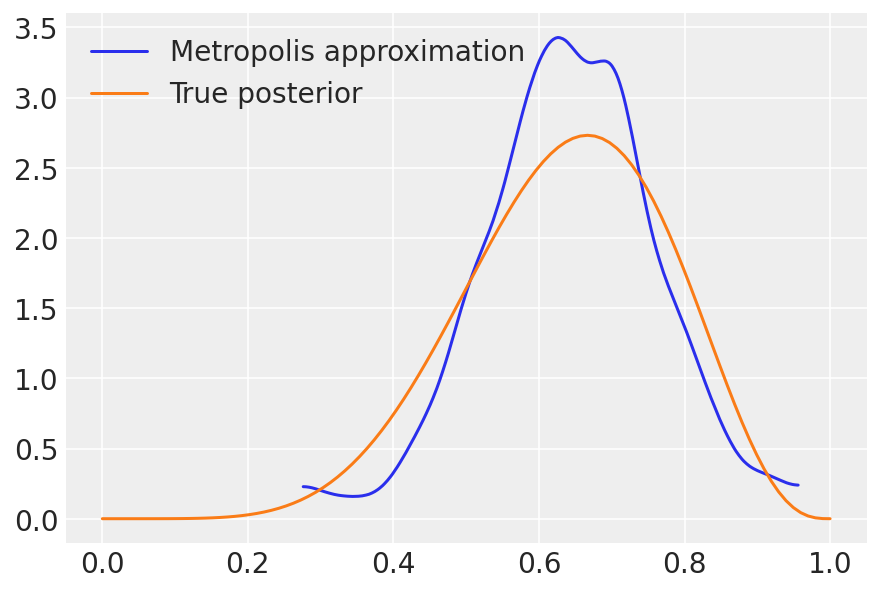

In [16]:
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Wed Nov 09 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

aesara: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

arviz     : 0.12.1
matplotlib: 3.6.0
pymc      : 4.1.7
numpy     : 1.23.3
scipy     : 1.9.1

Watermark: 2.3.1

